# Trial with CNN

In [1]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib seaborn
    import matplotlib.pyplot as plt
    
import numpy as np
import logging 

from neurolib.models.aln import ALNModel
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim

import pandas as pd
import matplotlib.pyplot as plt
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim

In [2]:
data=pd.read_csv("/Users/aliag/Desktop/EEG_Generation/ALN model trials/Linear model/data_0.csv")
data_np=np.transpose(np.array(data))
data_np

array([[-15.18061526, -11.02541637,  -7.87168798, ...,   0.9966213 ,
          1.74937484,   1.68081934],
       [ -3.35653613,  -3.47630088,  -3.40369614, ...,  -6.45510603,
         -6.52103405,  -5.74627718],
       [  8.9143698 ,  20.03423863,  27.45384339, ..., -31.47895816,
        -26.9286396 , -20.57683177],
       ...,
       [ -5.30931913,  -4.04592476,  -3.55016475, ...,   1.7496456 ,
          1.57671528,   3.01398251],
       [-22.65668852, -21.81436873, -20.48412455, ..., -19.21439823,
        -15.86088686, -11.0118054 ],
       [ -1.55028749,   0.80165608,   2.37325665, ...,   9.89673622,
          8.30458556,   7.07705594]])

## Prepare data

In [3]:
def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])
    
    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation and their labels."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    all_sets = []
    
    for index in fixation_indices:
        # Start from the next row after fixation and take the next 10 timestamps
        period = triggers.iloc[index + 1:index + 11]
        if not period.empty:
            initial_time = period['Time'].iloc[0]
            # Calculate relative times and labels for each event in the period
            relative_times = period['Time'].apply(lambda x: x - initial_time).tolist()
            labels = [1 if typ == 'target' else 0 for typ in period['Type']]
            all_sets.append([np.array(relative_times), np.array(labels)])
    
    return all_sets

trigger_files = [#'/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt', 
                   '/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/triggers_2.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/triggers.txt',
#                   '/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/triggers.txt',
#                  '/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/triggers.txt'
                 
                 ]

# Initialize sets_of_data outside the loop to accumulate data from all files
sets_of_data = []

for trigger_file in trigger_files:
    triggers = read_triggers(trigger_file)
    sets_of_data.extend(extract_fixation_periods(triggers))  # Extend to accumulate across files

In [4]:
def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])

    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    periods = []
    
    for index in fixation_indices:
        # Check if there are at least 10 entries after the fixation index
        end_index = index + 11
        if end_index > len(triggers):
            end_index = len(triggers)
        period = triggers.iloc[index + 1:end_index]
        if not period.empty:
            periods.append(period['Time'].tolist())
    
    return periods

import pandas as pd

def extract_data_from_intervals(raw_data_file, periods):
    """Extracts data rows corresponding to each period of timestamps and interpolates outliers."""
    raw_data_1 = pd.read_csv(raw_data_file, skiprows=2)
    raw_data = raw_data_1[20000:len(raw_data_1)-1]
    print(len(raw_data_1))
    # Calculate 5th and 95th percentiles to determine outliers
    low_quantiles = raw_data.quantile(0.05)
    high_quantiles = raw_data.quantile(0.95)

    # Mask values that are outliers
    is_outlier = (raw_data < low_quantiles) | (raw_data > high_quantiles)
    filtered_data = raw_data.where(~is_outlier, other=pd.NA)

    # Interpolate missing values that were marked as outliers
    interpolated_data = filtered_data.interpolate(method='linear', limit_direction='both')
    print(len(interpolated_data))
    results = []
    for period in periods:
        if period:
            # Get the start and end timestamps of the period
            start_time = period[0]
            end_time = period[-1]
            
            # Filter the data based on timestamps
            period_data = interpolated_data[(interpolated_data['lsl_timestamp'] >= start_time) & (interpolated_data['lsl_timestamp'] <= end_time)]
            period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
            # Calculate the average of certain columns, excluding some
            cols_to_avg = period_data.columns.difference(['lsl_timestamp', 'timestamp', 'relative_time', 'TRG', "X1","X2", "X3","A2","T3","T4","Fp1","Fp2","F7","F8","P3","P4","F3","F4","C3","C4"])
            period_data['average'] = period_data[cols_to_avg].mean(axis=1)
            results.append(period_data[cols_to_avg])
    print(cols_to_avg)
    
    return results, interpolated_data

# File pairs
file_pairs = [
     #('/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt', '/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/raw_data.csv'),
     ('/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/triggers_2.txt', '/Users/aliag/Desktop/Data/S002/S002_Matrix_Calibration_Thu_18_May_2023_12hr43min40sec_-0400/raw_data_2.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_Matrix_Calibration_Thu_18_May_2023_14hr33min55sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_RSVP_Calibration_Thu_18_May_2023_15hr02min41sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S003/S003_RSVP_Copy_Phrase_Thu_18_May_2023_15hr16min10sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/triggers.txt', '/Users/aliag/Desktop/Data/S005/S005_Matrix_Calibration_Wed_19_Jul_2023_09hr49min30sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S006/S006_Matrix_Calibration_Wed_19_Jul_2023_14hr22min54sec_-0400/raw_data.csv'),
     #('/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/triggers.txt','/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/raw_data.csv')
]

filtered_raw_data=[]
filtered_data_sets = []
for trigger_file, raw_data_file in file_pairs:
    triggers = read_triggers(trigger_file)
    fixation_periods = extract_fixation_periods(triggers)
    results, filtered_data=extract_data_from_intervals(raw_data_file, fixation_periods)
    filtered_data_sets.extend(results)
    filtered_raw_data.append(filtered_data)


315457
295456
Index(['Cz', 'Fz', 'O1', 'O2', 'Pz', 'T5', 'T6'], dtype='object')


/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_8318/2951039346.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['relative_time'] = period_data['lsl_timestamp'] - start_time
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_8318/2951039346.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['average'] = period_data[cols_to_avg].mean(axis=1)
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_8318/2951039346.py:58: SettingWithCopyWarning: 
A value is tr

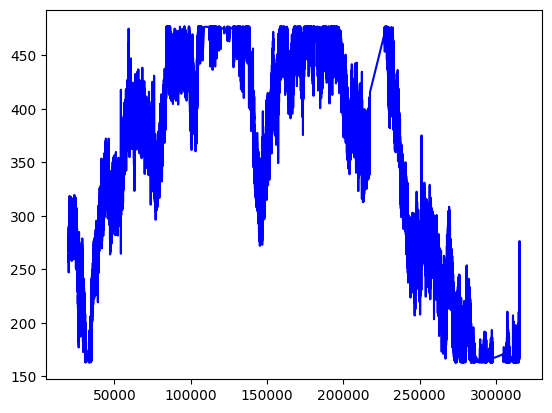

In [40]:
plt.plot(filtered_raw_data[0]['O1'], label='Combined Synaptic Input', color='blue')
plt.show()

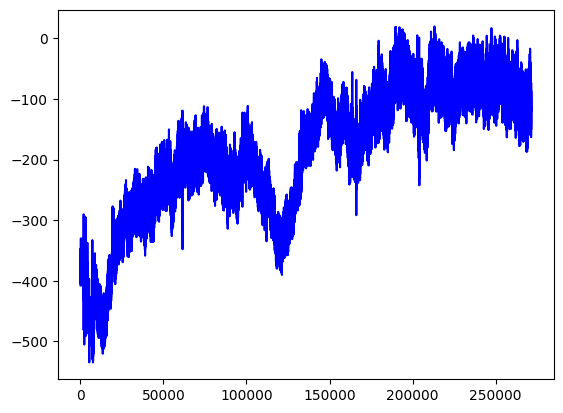

In [377]:
raw_data = pd.read_csv('/Users/aliag/Desktop/Data/S007/S007_Matrix_Calibration_Thu_20_Jul_2023_09hr48min56sec_-0400/raw_data.csv', skiprows=2)
plt.plot(raw_data['O1'], label='Combined Synaptic Input', color='blue')
plt.show()

In [106]:
print(len(filtered_data_sets))

200


In [5]:
def membrane_potential_thersholded(rates_exc, rates_inh, synaptic_efficiency, kernel_size, threshold):
    #combined_signal = rates
    
    #combined_signal = np.ravel(rates * 0.05)
    combined_signal = (rates_exc-rates_inh)*synaptic_efficiency

    # Create a square kernel for convolution
    square_kernel = np.ones(kernel_size) / kernel_size # Normalize the kernel to maintain amplitude scale

    # Convolve the combined signal with the square kernel
    convolved_signal = np.convolve(combined_signal, square_kernel, mode='same')

    # Apply a threshold to the convolved signal
    thresholded_signal = np.where(convolved_signal < threshold, convolved_signal, 0.1)
    return convolved_signal

In [6]:
import numpy as np

def square_signal_generator(dataset):
    time_array_2 = dataset[0]
    value_array_2 = dataset[1]
    new_size = 4000  # Convert to integer
    new_time_array_2 = np.linspace(time_array_2[0], time_array_2[-1], new_size)

    # Expand the value array to match the new time array, propagating labels
    new_value_array_2 = np.zeros_like(new_time_array_2)

    # Propagate values by setting the range of 1's between known points
    for i, value in enumerate(value_array_2):
        if value == 1:
            if i < len(value_array_2) - 1:
                next_change_index = np.where(value_array_2[i+1:] != value)[0]
                if len(next_change_index) > 0:
                    end_time = time_array_2[i + 1 + next_change_index[0]]
                else:
                    end_time = new_time_array_2[-1]
                start_index = np.searchsorted(new_time_array_2, time_array_2[i])
                end_index = np.searchsorted(new_time_array_2, end_time)
                new_value_array_2[start_index:end_index] = 1
            else:
                end_time = new_time_array_2[-1]
                end_index = np.searchsorted(new_time_array_2, end_time)
                new_value_array_2[end_index] = 1

    duration = 400
    dt = 0.1
    square_signal = new_value_array_2
    indices = np.where(square_signal == 1)[0]
    if len(indices)==0:
        inp = stim.ZeroInput(n=2).as_array(duration, dt)
    else:
        first_one = int(indices[0]/10)
        last_one = int(indices[-1]/10)
        inp = stim.StepInput(step_size=1, start=first_one, end=last_one, n=2).as_array(duration, dt)
    return inp, new_time_array_2

In [ ]:
['Cz', 'Fz', 'O1', 'O2', 'Pz', 'T5', 'T6']

# Data for multiple channel output

In [7]:
model = ALNModel()
model.params['duration'] = 400
model.params["sigma_ou"] = 0.1
values_Cz=[]
values_Fz=[]
values_O1=[]
values_O2=[]
values_Pz = []
values_T5 = []
valyes_T6 = []
square_signals=[]
rates=[]
rates_exc=[]
rates_inh=[]
synaptic_efficiency = 0.05  # Conversion from firing rate to synaptic current
kernel_size = 50  # Size of the square wave, represents the integration window in time steps
threshold = 0.5   # Threshold to highlight significant activity
times = []
model_output=[]
total_rates = []
for i in range(0, len(filtered_data_sets)-1):
    if(len(filtered_data_sets[i]['O1'][0:810])==810):
        values_Cz.append(np.array(filtered_data_sets[i]['Cz'][0:810]))
        values_Fz.append(np.array(filtered_data_sets[i]['Fz'][0:810]))
        values_O1.append(np.array(filtered_data_sets[i]['O1'][0:810]))
        #max_value = np.max(filtered_data_sets[i]['average'][0:810])
    #square_signal, time =square_signal_generator(sets_of_data[i], max_value)[0]
    square_signal, time =square_signal_generator(sets_of_data[i])[0]
    times.append(time)
    square_signals.append(square_signal)
    model.params["ext_exc_current"] = square_signal
    model.run()
    #rates.append(membrane_potential_thersholded(model.output.T, synaptic_efficiency, kernel_size, threshold))
    rates.append(membrane_potential_thersholded(model['rates_exc'][0],model['rates_inh'][0], synaptic_efficiency, kernel_size, threshold))
    rates_exc.append(model['rates_exc'][0])
    rates_inh.append(model['rates_inh'][0])
    exc_inh = (model['rates_exc'][0]-model['rates_inh'][0])*0.05
    total_rates.append(exc_inh)
    model_output.append(model.output.T)

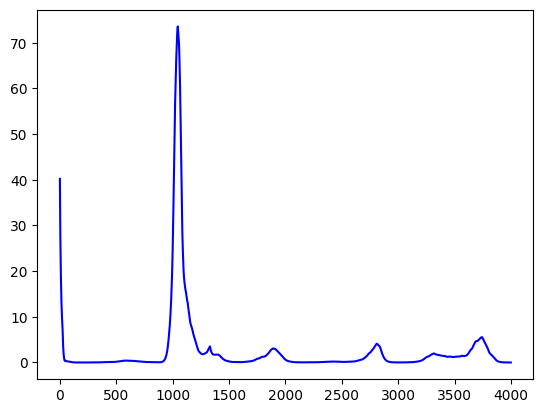

In [151]:
plt.plot(rates_exc[0], label='Combined Synaptic Input', color='blue')

plt.show()

In [150]:
values[0]['Cz']


50921    334.189575
50922    341.694183
50923    340.048309
50924    340.953369
50925    328.781464
            ...    
51726    295.107147
51727    295.414856
51728    294.218628
51729    293.912750
51730    287.598755
Name: Cz, Length: 810, dtype: float64

In [90]:
print(len(filtered_data_sets[50][['Cz', 'Fz', 'O1', 'O2', 'Pz', 'T5', 'T6']]))

1089


## Model

(73, 792)
torch.Size([73, 1, 4000])


/Users/aliag/.pyenv/versions/3.9.2/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 792])) that is different to the input size (torch.Size([32, 792])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/aliag/.pyenv/versions/3.9.2/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([26, 1, 792])) that is different to the input size (torch.Size([26, 792])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/aliag/.pyenv/versions/3.9.2/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15, 1, 792])) that is different to the input size (torch.Size([15, 792])). This will likely lead to incor

Epoch 1, Train Loss: 0.005542444065213203, Test Loss: 0.0058408863842487335
Epoch 2, Train Loss: 0.00581756979227066, Test Loss: 0.005747077986598015
Epoch 3, Train Loss: 0.005774190183728933, Test Loss: 0.005639371927827597
Epoch 4, Train Loss: 0.005479058250784874, Test Loss: 0.00552511727437377
Epoch 5, Train Loss: 0.005264548119157553, Test Loss: 0.005407517310231924
Epoch 6, Train Loss: 0.004411300178617239, Test Loss: 0.005288795102387667
Epoch 7, Train Loss: 0.00426145363599062, Test Loss: 0.005170171149075031
Epoch 8, Train Loss: 0.004853738471865654, Test Loss: 0.005052534397691488
Epoch 9, Train Loss: 0.004836407024413347, Test Loss: 0.004936596844345331
Epoch 10, Train Loss: 0.004914760123938322, Test Loss: 0.004823166411370039
Epoch 11, Train Loss: 0.004794006235897541, Test Loss: 0.004712698981165886
Epoch 12, Train Loss: 0.004580234177410603, Test Loss: 0.004605194553732872
Epoch 13, Train Loss: 0.00431615998968482, Test Loss: 0.004501084331423044
Epoch 14, Train Loss: 0.

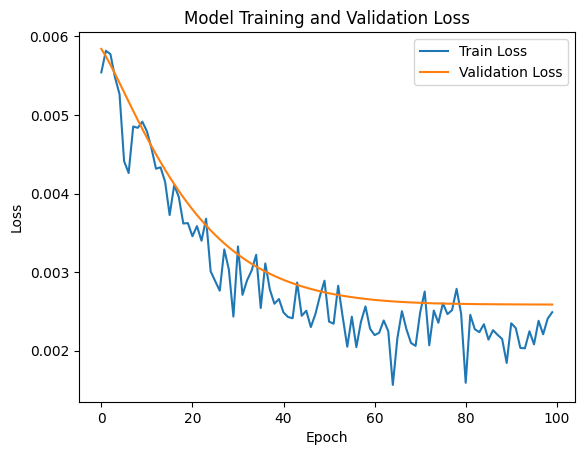

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the CNN model
class EEGCNN(nn.Module):
    def __init__(self):
        super(EEGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        # Assuming the output shape after the last pooling layer is (128, 499)
        self.fc1 = nn.Linear(63872, 100)
        self.fc2 = nn.Linear(100, 792)

    def forward(self, x):
        # Apply convolutions with learnable kernels
        x = self.pool1(torch.sigmoid(self.conv1(x)))
        x = self.pool2(torch.sigmoid(self.conv2(x)))
        x = self.pool3(torch.sigmoid(self.conv3(x)))  # Add pooling for conv3
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model instance
cnn_model = EEGCNN()

# Example data arrays, replace with your actual data
membrane_potentials = torch.tensor(total_rates[0:73]).reshape(73, 1, 4000).float()  # Ensure this matches the model input shape
values_mV=np.array(data_np[0:73])/1000
print(values_mV.shape)
print(membrane_potentials.shape)
real_eeg_data = torch.tensor(values_mV).reshape(73, 1, 792).float()         # Simulated EEG data
input_data_tensor = F.normalize(membrane_potentials, p=2, dim=2)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(membrane_potentials, real_eeg_data, test_size=0.2, random_state=42)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

train_losses = []
test_losses = []

# Training loop
num_epochs = 100
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
for epoch in range(num_epochs):
    cnn_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Calculate validation loss
    cnn_model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            outputs = cnn_model(inputs)
            test_loss += criterion(outputs, targets).item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

# Plot the training process
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_8318/2820346837.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_input = torch.tensor(X_test[4]).reshape(1, 1, 4000).float()


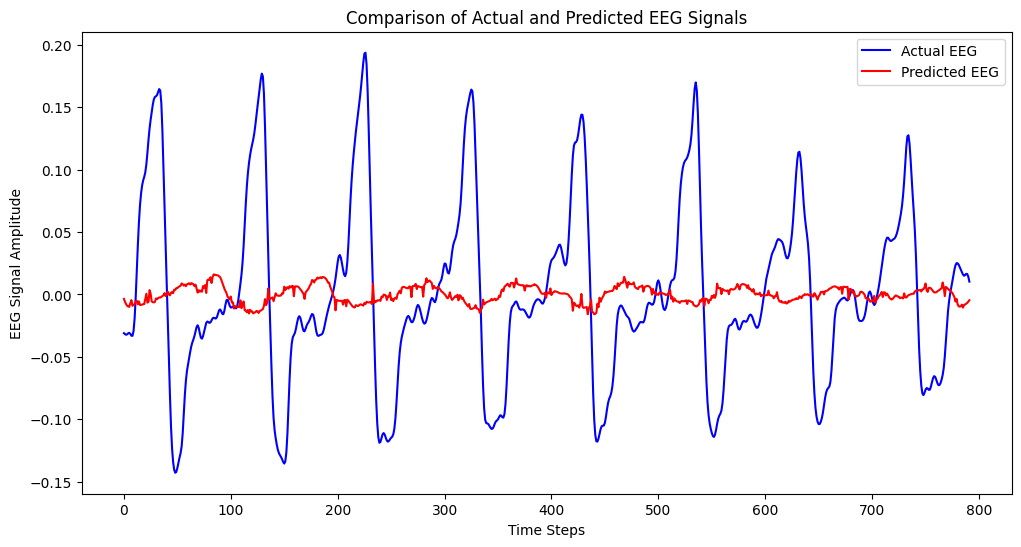

In [20]:

sample_input = torch.tensor(X_test[4]).reshape(1, 1, 4000).float()

# Make prediction
cnn_model.eval()
with torch.no_grad():
    prediction = cnn_model(sample_input)

# Convert prediction tensor to numpy array
prediction_array = prediction.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_test[4][0], label='Actual EEG', color='blue')
plt.plot(prediction_array, label='Predicted EEG', color='red')
plt.title('Comparison of Actual and Predicted EEG Signals')
plt.xlabel('Time Steps')
plt.ylabel('EEG Signal Amplitude')
plt.legend()
plt.show()

In [116]:
print(len(X_test[0][0]))

4000


In [114]:
print(len(prediction_array))

7


## Rates_exc and rates_inh as separated input

Epoch 1, Train Loss: 0.07577389478683472, Test Loss: 0.04221365228295326
Epoch 2, Train Loss: 0.027735430747270584, Test Loss: 0.026992276310920715
Epoch 3, Train Loss: 0.022470584139227867, Test Loss: 0.03147119656205177
Epoch 4, Train Loss: 0.03128242865204811, Test Loss: 0.028287967666983604
Epoch 5, Train Loss: 0.021245790645480156, Test Loss: 0.02240748144686222
Epoch 6, Train Loss: 0.017618857324123383, Test Loss: 0.01906786859035492
Epoch 7, Train Loss: 0.0230510663241148, Test Loss: 0.018126260489225388
Epoch 8, Train Loss: 0.013586348854005337, Test Loss: 0.017662817612290382
Epoch 9, Train Loss: 0.01326989196240902, Test Loss: 0.015907691791653633
Epoch 10, Train Loss: 0.01202489249408245, Test Loss: 0.014202131889760494
Epoch 11, Train Loss: 0.011079106479883194, Test Loss: 0.013459241017699242
Epoch 12, Train Loss: 0.010570617392659187, Test Loss: 0.013061340898275375
Epoch 13, Train Loss: 0.014461792074143887, Test Loss: 0.012547556310892105
Epoch 14, Train Loss: 0.0138811

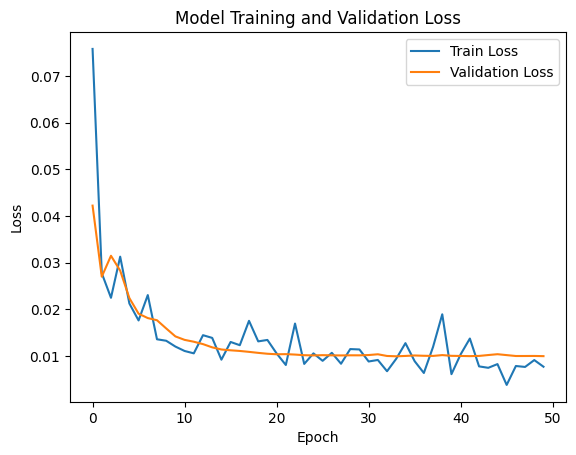

In [218]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Define the CNN model
class EEGCNN(nn.Module):
    def __init__(self):
        super(EEGCNN, self).__init__()
        self.linear = nn.Linear(8000, 4000)  # Initial linear layer
        self.conv1 = nn.Conv1d(1, 32, kernel_size=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        # Assuming the output shape after the last pooling layer is (128, 499)
        self.fc1 = nn.Linear(128*499, 100)
        self.fc2 = nn.Linear(100, 810)

    def forward(self, x):
        x = x.view(-1, 8000)  # Reshape the input to fit the linear layer
        x = torch.sigmoid(self.linear(x))  # Apply the initial linear layer
        x = x.view(-1, 1, 4000)  # Reshape to match the expected input shape of the convolutional layer
        x = self.pool1(torch.sigmoid(self.conv1(x)))
        x = self.pool2(torch.sigmoid(self.conv2(x)))
        x = self.pool3(torch.sigmoid(self.conv3(x)))  # Add pooling for conv3
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model instance
cnn_model = EEGCNN()

# Assuming rates_exc, rates_inh, and values_mV are defined elsewhere
rates_exc_tensor = torch.tensor(rates_exc_del[0:57]).float().unsqueeze(1)  # Add channel dimension
rates_inh_tensor = torch.tensor(rates_inh_del[0:57]).float().unsqueeze(1)  # Add channel dimension
input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
values_mV=np.array(values_O1_del[0:57])/1000
real_eeg_data = torch.tensor(values_mV).float()  # Simulated EEG data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(input_data_tensor, real_eeg_data, test_size=0.2, random_state=42)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.03)

train_losses = []
test_losses = []

# Training loop
num_epochs = 50
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
for epoch in range(num_epochs):
    cnn_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Calculate validation loss
    cnn_model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            outputs = cnn_model(inputs)
            test_loss += criterion(outputs, targets).item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

# Plot the training process
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_97830/2787709421.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_input = torch.tensor(X_test[2]).reshape(1, 2, 4000).float()


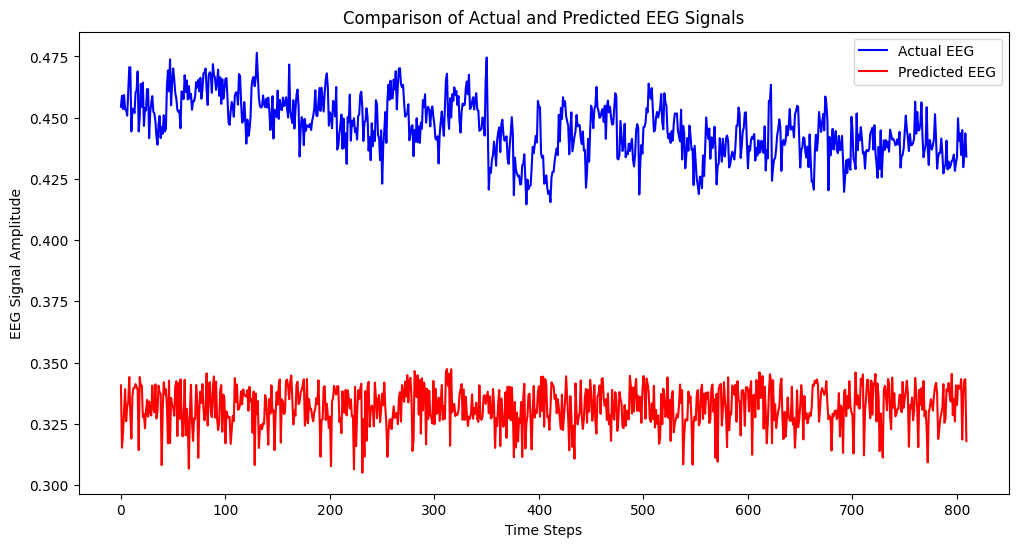

In [219]:
sample_input = torch.tensor(X_test[2]).reshape(1, 2, 4000).float()

# Make prediction
cnn_model.eval()
with torch.no_grad():
    prediction = cnn_model(sample_input)

# Convert prediction tensor to numpy array
prediction_array = prediction.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_test[2], label='Actual EEG', color='blue')
plt.plot(prediction_array, label='Predicted EEG', color='red')
plt.title('Comparison of Actual and Predicted EEG Signals')
plt.xlabel('Time Steps')
plt.ylabel('EEG Signal Amplitude')
plt.legend()
plt.show()

# Model with multiple channels as output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the CNN model
class EEGCNN(nn.Module):
    def __init__(self):
        super(EEGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*499, 100)
        self.fc2 = nn.Linear(100, 5670)  # Output size changed to 7*810=5670

    def forward(self, x):
        x = self.pool1(torch.sigmoid(self.conv1(x)))
        x = self.pool2(torch.sigmoid(self.conv2(x)))
        x = self.pool3(torch.sigmoid(self.conv3(x)))
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x).view(-1, 7, 810)  # Reshape to (batch_size, 7, 810)
        return x

# Create the model instance
cnn_model = EEGCNN()

# Example data arrays, replace with your actual data
membrane_potentials = torch.tensor(total_rates[0:73]).reshape(73, 1, 4000).float()  # Ensure this matches the model input shape
values_mV = np.array(values[0:73]) / 1000
real_eeg_data = torch.tensor(values_mV).reshape(73, 7, 810).float()  # Reshape to match output size
input_data_tensor = F.normalize(membrane_potentials, p=2, dim=2)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(input_data_tensor, real_eeg_data, test_size=0.2, random_state=42)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

train_losses = []
test_losses = []

# Training loop
num_epochs = 100
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
for epoch in range(num_epochs):
    cnn_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # Calculate validation loss
    cnn_model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, targets in test_loader:
            outputs = cnn_model(inputs)
            test_loss += criterion(outputs, targets).item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

# Plot the training process
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Joining models

## Deap utils functions

In [223]:
# This file contains helper functions for DEAP
# including additional mutation, crossover and selection operators.

import random
import copy
import numpy as np


# def indivAsDict_adapt(individual, ParametersInterval, paramInterval):
#     """
#     Convert an individual to a dictionary
#     """
#     return ParametersInterval(*(individual[: len(paramInterval)]))._asdict().copy()


def randomParameters(paramInterval):
    """
    Generate a sequence of random parameters from a ParamsInterval using a uniform distribution.
    Format: [mean_par1, mean_par2, ...]
    """
    params = [np.random.uniform(*pI) for pI in paramInterval]
    return params

def randomParametersAdaptive(paramInterval):
    """
    Generate a sequence of random parameters from a ParamsInterval using a uniform distribution.
    Format: [mean_par1, mean_par2, ..., sigma_par1, sigma_par2, ...]
    The second half of the parameter list is set of adaptive mutation std deviation parameters.
    """
    params = []
    for key, interval in paramInterval.items():
        params.append(np.random.uniform(interval[0], interval[1]))
    # The initial adaptation parameters are chosen according to the initial parameter range:
    defaultAdaptation = [abs(interval[1] - interval[0]) / 3 for interval in paramInterval.values()]
    # add sigma's to the list of means
    params.extend(defaultAdaptation)
    return params


def mutateUntilValid(pop, paramInterval, MUTATE_P={}, maxTries=100):
    """Checks the validity of new individuals' parameter. If they are invalid 
    (for example if they are out of the predefined parameter space bounds), 
    mutate the individual, until valid.

    :param pop: population to mutate
    :param paramInterval: parameter interval dictionary
    :param MUTATE_P: mutation parameters (e.g., {'sigma_scale': 2.0})
    :param maxTries: how many mutations to try until valid
    """
    intervals=[]
    for key, interval in paramInterval.items():
        intervals.append(interval)
    for i, ind in enumerate(pop):
        ind_bak = copy.copy(ind)
        ind = mutateIndividual(ind, paramInterval, MUTATE_P)
        nMutations = 0
        while not checkParamValidity(ind, paramInterval) and nMutations < maxTries:
            ind = copy.copy(ind_bak)
            ind = mutateIndividual(ind, paramInterval, MUTATE_P)
            nMutations += 1

        # If it didn't work, set the individual to the boundary
        for j, interval in enumerate(intervals):
            if ind[j] < interval[0]:
                ind[j] = float(interval[0])
            elif ind[j] > interval[1]:
                ind[j] = float(interval[1])
        
        pop[i] = ind

def mutateIndividual(individual, paramInterval, MUTATE_P={}):
    """
    Mutate an individual.
    """
    intervals=[]
    for key, interval in paramInterval.items():
        intervals.append(interval)
    for i, interval in enumerate(intervals):
        if random.random() < MUTATE_P.get('indpb', 0.05):
            individual[i] = random.uniform(interval[0], interval[1])
    return individual

def checkParamValidity(individual, paramInterval):
    """
    Check if an individual is within the specified bounds.
    Return True if it is correct, False otherwise.
    """
    intervals=[]
    for key, interval in paramInterval.items():
        intervals.append(interval)
    for i, interval in enumerate(intervals):
        if individual[i] < interval[0] or individual[i] > interval[1]:
            return False
    return True





### Selection operators ###
# Rank selection
def selRank(pop, k, s=1.5):
    """
    Select k individuals from a population using rank selection. (Eiben&Smith, p.81)
    Individuals are selected according to the fitness rank.
    To support multiobjective fitness functions, the weighted sum of fitness is used.

    :param pop: population
    :type pop: list
    :param k: number of individuals to select
    :type k: int
    :param s: selection probability parameter
    :type s: float

    :return: population of selected individuals
    :rtype: list
    """
    # Sort individual according to their rank, the first indiv in the list is the one with the best fitness
    s_inds = sorted(pop, key=lambda iv: np.nansum(iv.fitness.wvalues), reverse=True)

    mu = len(pop)

    # Probability of drawing individuals i in s_inds
    P_indiv = ((2 - s) / mu + 2 * (s - 1) / (mu * (mu - 1)) * np.arange(mu)).tolist()
    P_indiv.reverse()

    sum_P = sum(P_indiv)

    chosen = []
    for i in range(k):
        u = random.random() * sum_P
        sum_ = 0
        for i, ind in enumerate(s_inds):
            sum_ += P_indiv[i]
            if sum_ > u:
                chosen.append(ind)
                break
    return chosen


# # Wheel selection
# # This code is not compatible with multiobjective fitness functions! Use np.nansum(iv.fitness.wvalues) instead!
# def selWheel(individuals,k):
#     '''
#     Select k individual from a population using the Roulette selection
#     Since we are trying to minimize the distance, we use the inverse fitness function as a probability

#     This code is inspired from DEAP.toolbox.selRoulette
#     '''
#     s_inds = sorted(individuals, key=attrgetter("fitness"), reverse=True)
#     sum_invfits = sum(1/ind.fitness.values[0] for ind in individuals)

#     chosen = []
#     for i in range(k):
#         u = random.random() * sum_invfits
#         sum_ = 0
#         for ind in s_inds:
#             sum_ += 1 / ind.fitness.values[0]
#             if sum_ > u:
#                 chosen.append(ind)
#                 break
#     return chosen


# Select best
def selBest_multiObj(pop, k):
    """
    Select the best k individuals.

    This function accept multiobjective function by summing the fitness all of objectives.
    """
    # Sort individual according to their rank, the first indiv in the list is the one with the best fitness
    return sorted(pop, key=lambda iv: np.nansum(iv.fitness.wvalues), reverse=True)[:k]


# ### Crossover operators ###

# # This crossover was taken from DEAP but modified to
# #   - add a boolean return value giving information on if a crossover happenned
# #   - switch the adaptive mutation rate too
# def cxUniform_adapt(ind1, ind2, indpb):
#     """Executes a uniform crossover that modify in place the two
#     :term:`sequence` individuals. The attributes are swapped according to the
#     *indpb* probability.
#     The individuals are composed of the gene values first and then the mutation rates.

#     :param ind1: The first individual participating in the crossover.
#     :param ind2: The second individual participating in the crossover.
#     :param indpb: Independent probabily for each attribute to be exchanged.
#     :returns: A tuple of two individuals.

#     This function uses the :func:`~random.random` function from the python base
#     :mod:`random` module.
#     """
#     size = min(len(ind1), len(ind2))
#     for i in range(size // 2):
#         if random.random() < indpb:
#             ind1[i], ind2[i] = ind2[i], ind1[i]
#             iAdapt = i + size // 2
#             ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]

#     return ind1, ind2


# def cxUniform_normDraw(ind1, ind2, indpb):
#     """Executes a uniform crossover that modify in place the two individuals.
#     The attributes of the 2 individuals are set according to a normal distribution whose mean is
#     the mean between both individual attributes and the standard deviation the distance between the 2 attributes.
#     The individuals are composed of the gene values first and then the mutation rates.

#     Warning: a check should be done afterward on the parameter to be sure they are not out of bound.

#     :param ind1: The first individual participating in the crossover.
#     :param ind2: The second individual participating in the crossover.
#     :param indpb: Independent probabily for each attribute to be exchanged.
#     :returns: A tuple of two individuals.

#     This function uses the :func:`~random.random` function from the python base
#     :mod:`random` module.
#     """
#     size = min(len(ind1), len(ind2))
#     for i in range(size // 2):
#         if random.random() < indpb:
#             mu = np.mean([ind1[i], ind2[i]])
#             sigma = np.abs(ind1[i] - ind2[i])
#             ind1[i] = random.normalvariate(mu, sigma)
#             ind2[i] = random.normalvariate(mu, sigma)

#     return ind1, ind2


def cxNormDraw_adapt(ind1, ind2, sigma_scale=2.0):
    """The new attributes of the two individuals are set according to a normal distribution whose mean is
    the mean between both individual's attributes and the standard deviation being the distance between the two attributes.
    
    Similar to mutation parameter described in Ono et al 2003 but with only 2 parents (and not 3).

    Info: The individuals are composed of the gene values first and then the mutation rates.
    Warning: a check should be done afterward on the parameter to be sure they are not out of bound.

    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :param sigma_scale: Scaling of sigma (distance of parents / sigma_scale)
    :returns: A tuple of two individuals.

    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    for i in range(size // 2):
        mu = float(np.mean([ind1[i], ind2[i]]))
        sigma = float(np.abs(ind1[i] - ind2[i])) / sigma_scale
        # In Ono 2003, they draw only one random number r and
        # ind1 = mean - r * sigma
        # ind2 = mean + r * sigma
        # We draw two independent parameters here
        ind1[i] = random.gauss(mu, sigma)  # in-place modification!
        ind2[i] = random.gauss(mu, sigma)

        iAdapt = i + size // 2  # adaptive parameters, start at half of the list
        # ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]
        mu_adapt = float(np.mean([ind1[iAdapt], ind2[iAdapt]]))
        sigma_adapt = float(np.abs(ind1[iAdapt] - ind2[iAdapt])) / sigma_scale
        ind1[iAdapt] = random.gauss(mu_adapt, sigma_adapt)
        ind2[iAdapt] = random.gauss(mu_adapt, sigma_adapt)

    return ind1, ind2


def cxUniform_adapt(ind1, ind2, indpb):
    """The new attributes of the two individuals are set according to a normal distribution whose mean is
    the mean between both individual's attributes and the standard deviation being the distance between the two attributes.
    
    Info: The individuals are composed of the gene values first and then the mutation rates.
    Warning: a check should be done afterward on the parameter to be sure they are not out of bound.

    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :param indpb: Independent probabily for each attribute to be exchanged.
    :returns: A tuple of two individuals.

    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    for i in range(size // 2):
        if random.random() < indpb:
            ind1[i], ind2[i] = ind2[i], ind1[i]  # in-place modification!
            iAdapt = i + size // 2  # adaptive parameters, start at half of the list
            ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]

    return ind1, ind2


def cxUniform_normDraw_adapt(ind1, ind2, indpb):
    """Executes a uniform crossover that modify in place the two
    :term:`sequence` individuals.
    The attributes of the 2 individuals are set according to a normal distribution whose mean is
    the mean between both individual attributes and the standard deviation the distance between the 2 attributes.
    The individuals are composed of the gene values first and then the mutation rates.
    Warning: a check should be done afterward on the parameter to be sure they are not out of bound.
    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :param indpb: Independent probabily for each attribute to be exchanged.
    :returns: A tuple of two individuals.
    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    for i in range(size // 2):
        if random.random() < indpb:
            mu = float(np.mean([ind1[i], ind2[i]]))
            sigma = float(np.abs(ind1[i] - ind2[i])) / 4
            ind1[i] = random.normalvariate(mu, sigma)  # in-place modification!
            ind2[i] = random.normalvariate(mu, sigma)  # in-place modification!
            iAdapt = i + size // 2  # adaptive parameters, start at half of the list
            ind1[iAdapt], ind2[iAdapt] = ind2[iAdapt], ind1[iAdapt]

    return ind1, ind2


### Mutation operators ###

# Adaptive mutation with m different stepsizes
def gaussianAdaptiveMutation_nStepSizes(individual, gamma_gl=None, gamma=None):
    """
    Perform an uncorrelated adaptive mutation with n step sizes on the individual

    Warning: the mutations is in place, i.e. it modifies the given individual
    Parameters:
        :param individual: Inidivual to mutate. This should a sequence of length 2 * n_params 
        the last n_params elements being the individual adaptation rates)
        :param gamma_gl: Global adaptive mutation param ( should be proportional to 1/sqrt(2 n_params ) )
        :param gamma: Adaptive mutation parameters ( should be proportional to 1/sqrt(2 sqrt(n_params) ) )

    :returns: the individual

    """
    n_params = len(individual) // 2
    oldParams = individual[0:n_params]
    oldSigmas = individual[n_params:]

    if gamma_gl is None:
        gamma_gl = 1 / np.sqrt(2 * n_params)

    if gamma is None:
        gamma = 1 / np.sqrt(2 * np.sqrt(n_params))

    randn_global = float(np.random.randn())

    newSigmas = [
        oldSigmas[i] * float(np.exp(gamma * float(np.random.randn()) + gamma_gl * randn_global))
        for i in range(n_params)
    ]
    newParams = [oldParams[i] + newSigmas[i] * float(np.random.randn()) for i in range(n_params)]

    individual[:] = newParams + newSigmas

    return (individual,)

In [224]:
def generateRandomICs(N, seed=None):
    """Generates random Initial Conditions for the interareal network

    :params N:  Number of area in the large scale network

    :returns:   A tuple of 9 N-length numpy arrays representining:
                    mufe_init, IA_init, mufi_init, sem_init, sev_init,
                    sim_init, siv_init, rates_exc_init, rates_inh_init
    """
    np.random.seed(seed)

    mufe_init = 3 * np.random.uniform(0, 1, (N,))  # mV/ms
    mufi_init = 3 * np.random.uniform(0, 1, (N,))  # mV/ms
    seem_init = 0.5 * np.random.uniform(0, 1, (N,))
    seim_init = 0.5 * np.random.uniform(0, 1, (N,))
    seev_init = 0.001 * np.random.uniform(0, 1, (N,))
    seiv_init = 0.001 * np.random.uniform(0, 1, (N,))
    siim_init = 0.5 * np.random.uniform(0, 1, (N,))
    siem_init = 0.5 * np.random.uniform(0, 1, (N,))
    siiv_init = 0.01 * np.random.uniform(0, 1, (N,))
    siev_init = 0.01 * np.random.uniform(0, 1, (N,))
    rates_exc_init = 0.01 * np.random.uniform(0, 1, (N, 1))
    rates_inh_init = 0.01 * np.random.uniform(0, 1, (N, 1))
    IA_init = 200.0 * np.random.uniform(0, 1, (N, 1))  # pA

    return (
        mufe_init,
        mufi_init,
        IA_init,
        seem_init,
        seim_init,
        seev_init,
        seiv_init,
        siim_init,
        siem_init,
        siiv_init,
        siev_init,
        rates_exc_init,
        rates_inh_init,
    )

In [248]:
class param_layer(nn.Module):
    def __init__(self):
        super(param_layer, self).__init__()
        self.fc = nn.Linear(5, 5)  # Output size changed to 7*810=5670

    def forward(self, x):
        x = self.fc(x)
        return x

In [238]:
import random
import numpy as np
from neurolib.models.aln import ALNModel
ALNmodel = ALNModel()
# Define the fitness function
def evaluate(individual, ALNmodel, duration, sigma_ou, square_signals, cnn_model, values):

    paramInterval = {
        "sigma_ou": (0.0, 0.9),
        "mue_ext_mean": (0.0, 4.0),
        "mui_ext_mean": (0.0, 4.0),
        "EA": (-80.0, 80.0),
        "tauA": (100.0, 200.0)
    }

    total_rates = []
    predictions = []
    rates_exc = []
    rates_inh = []
    model.params['duration'] = 400

    for param_name, param_value in zip(paramInterval.keys(), individual):
        model.params[param_name] = param_value

    total_loss = 0
    for i in range(0, 88):
        model.params["ext_exc_current"] = square_signals[i]
        model.run()
        #rates_syn = (model['rates_exc'][0] - model['rates_inh'][0]) * 0.05
        rates_exc.append(model['rates_exc'][0])
        rates_inh.append(model['rates_inh'][0])
        rates_exc_tensor = torch.tensor(model['rates_exc'][0]).float().unsqueeze(1)  # Add channel dimension
        rates_inh_tensor = torch.tensor(model['rates_inh'][0]).float().unsqueeze(1)  # Add channel dimension
        input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
        torch.tensor(input_data_tensor).reshape(1, 2, 4000).float()
        #total_rates.append(rates_syn)
        with torch.no_grad():
            prediction = cnn_model(sample_input)
            # Convert prediction tensor to numpy array
            prediction_array = prediction.squeeze().numpy()
        predictions.append(prediction_array)
        #mse = np.mean(y_e[0] - values[i]) ** 2
        #total_loss += mse

    total_loss2 = np.mean(np.array(predictions) - np.array(values)) ** 2
    #X = np.array(total_rates[0:88])
    #y = values[0:88]

    rates_exc_tensor = torch.tensor(rates_exc).float().unsqueeze(1)  # Add channel dimension
    rates_inh_tensor = torch.tensor(rates_inh).float().unsqueeze(1)  # Add channel dimension
    input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
    values_mV=np.array(values_O1[0:88])/1000
    real_eeg_data = torch.tensor(values_mV).float()  # Simulated EEG data

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(input_data_tensor, real_eeg_data, test_size=0.2, random_state=42)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.03)

    train_losses = []
    test_losses = []

    # Training loop
    num_epochs = 5
    batch_size = 16
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    for epoch in range(num_epochs):
        cnn_model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        # Calculate validation loss
        cnn_model.eval()
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                outputs = cnn_model(inputs)
                test_loss += criterion(outputs, targets).item()
            test_loss /= len(test_loader)
            test_losses.append(test_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    fitness_tuple = (total_loss, )
    return fitness_tuple, cnn_model


# Define the evolutionary algorithm
def evolutionary_algorithm(ALNmodel, duration, sigma_ou, square_signals, cnn_model, values, NGENERATIONS=10, pop_size=20):
    pop = []
    seed=np.random.seed(None)
    (
        mufe_init,
        mufi_init,
        IA_init,
        seem_init,
        seim_init,
        seev_init,
        seiv_init,
        siim_init,
        siem_init,
        siiv_init,
        siev_init,
        rates_exc_init,
        rates_inh_init,
    ) = generateRandomICs(1, seed)
    (
        mufe_init2,
        mufi_init2,
        IA_init2,
        seem_init2,
        seim_init2,
        seev_init2,
        seiv_init2,
        siim_init2,
        siem_init2,
        siiv_init2,
        siev_init2,
        rates_exc_init2,
        rates_inh_init2,
    ) = generateRandomICs(1, seed )

    paramInterval = {
        "sigma_ou": (0.0, 0.9),   # Parameter 1: Min = -5.0, Max = 5.0
        "mue_ext_mean": (0.0, 4.0),   # Parameter 2: Min = -3.0, Max = 3.0
        "mui_ext_mean": (0.0, 4.0),
        "EA" : (-80.0,80.0), # mV
        "tauA" : (100.0,200.0),
    }

    for _ in range(pop_size):
        individual = randomParametersAdaptive(paramInterval)
        fitness, cnn_model = evaluate(individual, ALNmodel, duration, sigma_ou, square_signals, cnn_model, values)
        pop.append((individual, fitness)) 
    for gen in range(NGENERATIONS):
        # Select parents
        parents = random.sample(pop, 2)
        parent1, parent2 = parents[0][0], parents[1][0]

        # Crossover
        child = []
        for p1, p2 in zip(parent1, parent2):
            if random.random() < 0.5:
                child.append(p1)
            else:
                child.append(p2)

        # Mutation
        mutateUntilValid([child], paramInterval, MUTATE_P={'sigma_scale': 2.0})

        # Evaluate child
        fitness, cnn_model = evaluate(child, ALNmodel, duration, sigma_ou, square_signals, cnn_model, values)
        pop.append((child, fitness))

        # Select survivors
        pop = sorted(pop, key=lambda x: x[1])
        pop = pop[:pop_size]

    # Get the best individual
    best_individual, best_fitness = min(pop, key=lambda x: x[1])
    return best_individual, best_fitness, cnn_model

# Run the evolutionary algorithm
best_individual, best_fitness, linear_model_new = evolutionary_algorithm(ALNmodel, 400, 0.2, square_signals, cnn_model, values_O1)

# Print the best individual's fitness and parameters
print("Best individual:", best_individual[0:5])
print("Best fitness:", best_fitness)


/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_97830/2553548007.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(input_data_tensor).reshape(1, 2, 4000).float()


Epoch 1, Train Loss: 0.01395639218389988, Test Loss: 0.019181009382009506
Epoch 2, Train Loss: 0.007308206520974636, Test Loss: 0.030217443592846394
Epoch 3, Train Loss: 0.003863423829898238, Test Loss: 0.016297585796564817
Epoch 4, Train Loss: 0.008513330481946468, Test Loss: 0.0193120576441288
Epoch 5, Train Loss: 0.007783972192555666, Test Loss: 0.02031733188778162
Epoch 1, Train Loss: 0.018887292593717575, Test Loss: 0.025529535487294197
Epoch 2, Train Loss: 0.0246648620814085, Test Loss: 0.03460265137255192
Epoch 3, Train Loss: 0.008114109747111797, Test Loss: 0.01719734352082014
Epoch 4, Train Loss: 0.00846592802554369, Test Loss: 0.017427430488169193
Epoch 5, Train Loss: 0.023062216117978096, Test Loss: 0.022089037112891674
Epoch 1, Train Loss: 0.0076555488631129265, Test Loss: 0.035641757771372795
Epoch 2, Train Loss: 0.019138015806674957, Test Loss: 0.016010092105716467
Epoch 3, Train Loss: 0.006999659352004528, Test Loss: 0.026796712540090084
Epoch 4, Train Loss: 0.0096875857

/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_97830/2983428728.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_input = torch.tensor(X_test[2]).reshape(1, 2, 4000).float()


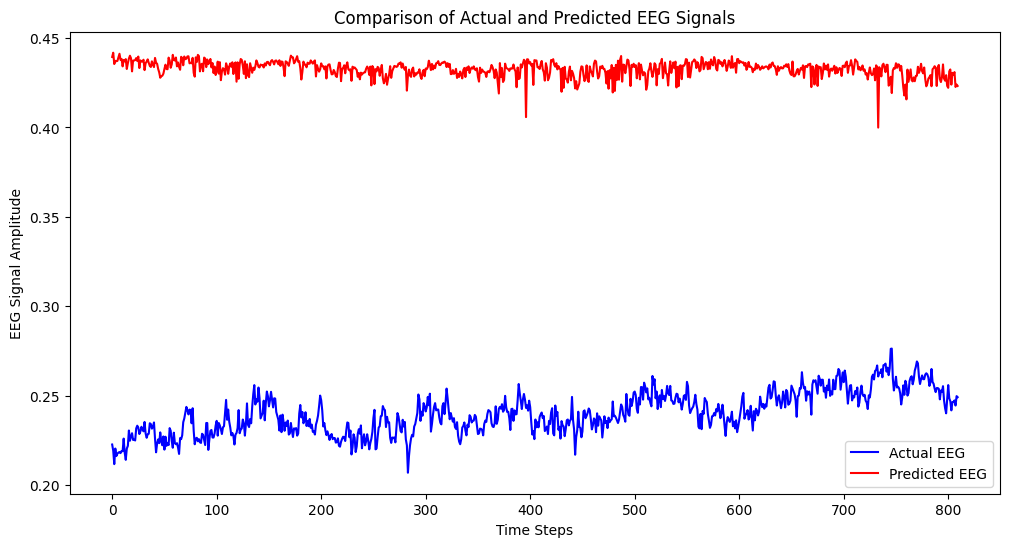

In [244]:
model.params["sigma_ou"]=0.63
model.params["mue_ext_mean"]=1.30
model.params["mui_ext_mean"]=3.69
model.params["EA"]=-67.28
model.params["tauA"]=147.15
#model.params["mufe_init"]=np.array([1.35])
#model.params["mufi_init"]=np.array([2.16])
model.params["ext_exc_current"] = square_signals[0]
model.run()
sample_input = torch.tensor(X_test[2]).reshape(1, 2, 4000).float()
rates_exc_tensor = torch.tensor(model['rates_exc'][0]).float().unsqueeze(1)  # Add channel dimension
rates_inh_tensor = torch.tensor(model['rates_inh'][0]).float().unsqueeze(1)  # Add channel dimension
input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
# Make prediction
linear_model_new.eval()
with torch.no_grad():
    prediction = linear_model_new(input_data_tensor)

# Convert prediction tensor to numpy array
prediction_array = prediction.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(np.array(values_O1[0])/1000, label='Actual EEG', color='blue')
plt.plot(prediction_array, label='Predicted EEG', color='red')
plt.title('Comparison of Actual and Predicted EEG Signals')
plt.xlabel('Time Steps')
plt.ylabel('EEG Signal Amplitude')
plt.legend()
plt.show()

# Learn parameters with a linear layer

In [294]:
class param_layer(nn.Module):
    def __init__(self):
        super(param_layer, self).__init__()
        self.fc = nn.Linear(3, 3)  # Output size changed to 7*810=5670

    def forward(self, x):
        x = self.fc(x)
        return x


In [263]:
optimizer2 = optim.Adam(param_layer().parameters(), lr=0.001)

In [296]:
cnn_model = EEGCNN()
param_layer_model = param_layer()
model = ALNModel()
# Define the loss function and optimizers
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer2 = optim.Adam(param_layer_model.parameters(), lr=0.001)

params = torch.randn(1, 3)

total_loss = 0
for i in range(0,20):
    model.params['duration'] = 400
    param_layer_output = param_layer_model(params)
    params = param_layer_output
    print(params)
    rates_exc = []
    rates_inh = []
    for i in range(0, 88):
        model.params["ext_exc_current"] = square_signals[i]
        params_float = [float(param) for param in param_layer_output[0]]
        # Update ALN model parameters
        model.params["mue_ext_mean"], model.params["mui_ext_mean"], model.params["sigma_ou"] = params_float

        model.run()
        rates_exc.append(model['rates_exc'][0])
        rates_inh.append(model['rates_inh'][0])

    rates_exc_tensor = torch.tensor(rates_exc).float().unsqueeze(1)
    rates_inh_tensor = torch.tensor(rates_inh).float().unsqueeze(1)
    input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
    values_mV = np.array(values_O1[0:88]) / 1000
    real_eeg_data = torch.tensor(values_mV).float()

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(input_data_tensor, real_eeg_data, test_size=0.2, random_state=42)

    # Training loop
    num_epochs = 5
    batch_size = 16
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        cnn_model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            optimizer2.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer2.step()

        # Calculate validation loss
        cnn_model.eval()
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                outputs = cnn_model(inputs)
                test_loss += criterion(outputs, targets).item()
            test_loss /= len(test_loader)

        print(f"Epoch {epoch+1}, Test Loss: {test_loss}")

tensor([[-0.1344, -1.0254, -0.4509]], grad_fn=<AddmmBackward0>)
Epoch 1, Test Loss: 0.11500723659992218
Epoch 2, Test Loss: 0.09693548455834389
Epoch 3, Test Loss: 0.08130068331956863
Epoch 4, Test Loss: 0.06806417182087898
Epoch 5, Test Loss: 0.057101551443338394
tensor([[ 0.0518, -0.2346, -0.2603]], grad_fn=<AddmmBackward0>)
Epoch 1, Test Loss: 0.04821430891752243
Epoch 2, Test Loss: 0.041119325906038284
Epoch 3, Test Loss: 0.03550597932189703
Epoch 4, Test Loss: 0.031096255406737328
Epoch 5, Test Loss: 0.027680018916726112
tensor([[ 0.1456, -0.1309, -0.4561]], grad_fn=<AddmmBackward0>)
Epoch 1, Test Loss: 0.02504683192819357
Epoch 2, Test Loss: 0.02304202225059271
Epoch 3, Test Loss: 0.021544241346418858
Epoch 4, Test Loss: 0.020480669103562832
Epoch 5, Test Loss: 0.01969249127432704
tensor([[ 0.2080, -0.0318, -0.4554]], grad_fn=<AddmmBackward0>)
Epoch 1, Test Loss: 0.019134895876049995
Epoch 2, Test Loss: 0.018689057789742947
Epoch 3, Test Loss: 0.018348041456192732
Epoch 4, Test L

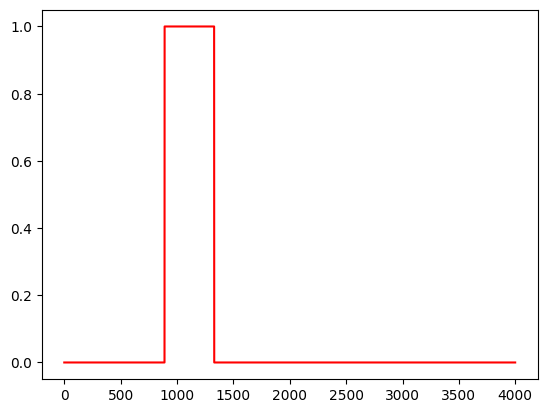

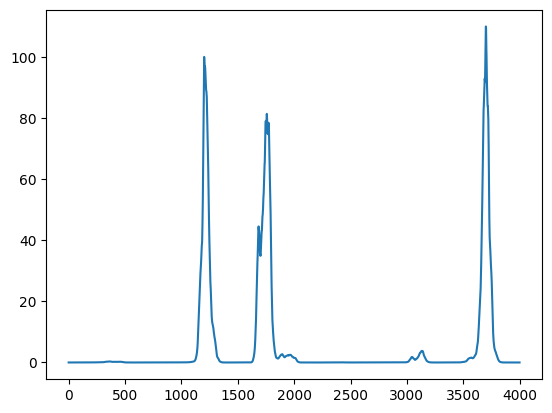

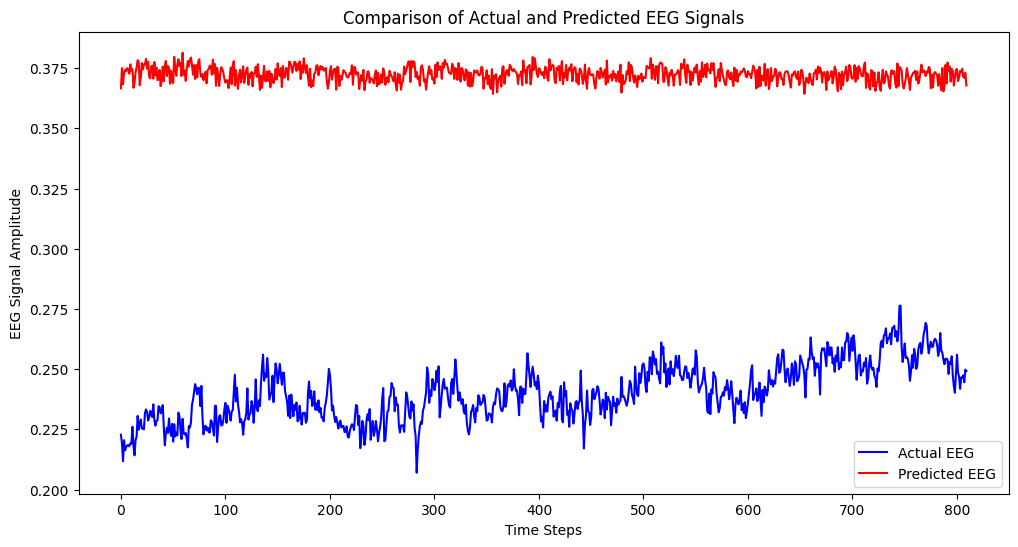

In [381]:
model.params["ext_exc_current"] = square_signals[0]
model.params['duration']=400
model.params["ext_exc_current"] = square_signals[0]
#model.params["mue_ext_mean"], model.params["mui_ext_mean"], model.params["sigma_ou"]=[ 0.2342, -0.0084, -0.4858]
model.run()
plt.plot(square_signals[0], c='r')
plt.show()
plt.plot(model['rates_exc'][0])
plt.show()
rates_exc_tensor = torch.tensor(model['rates_exc'][0]).float().unsqueeze(1)  # Add channel dimension
rates_inh_tensor = torch.tensor(model['rates_inh'][0]).float().unsqueeze(1)  # Add channel dimension
input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
# Make prediction
cnn_model.eval()
with torch.no_grad():
    prediction = cnn_model(input_data_tensor)

# Convert prediction tensor to numpy array
prediction_array = prediction.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(np.array(values_O1[0])/1000, label='Actual EEG', color='blue')
plt.plot(prediction_array, label='Predicted EEG', color='red')
plt.title('Comparison of Actual and Predicted EEG Signals')
plt.xlabel('Time Steps')
plt.ylabel('EEG Signal Amplitude')
plt.legend()
plt.show()

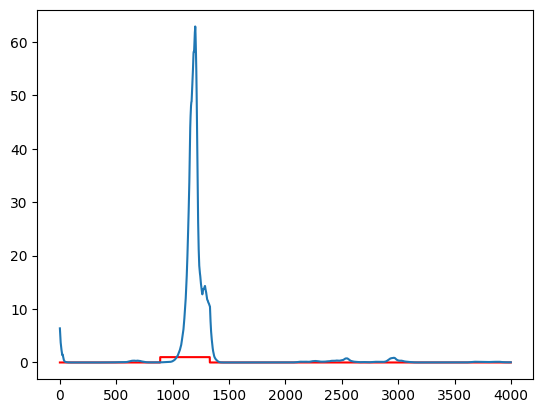

In [383]:
model = ALNModel()
model.params["ext_exc_current"] = square_signals[0]
model.params['duration']=400
model.params['sigma_ou']=0.2
model.run()
plt.plot(square_signals[0], c='r')
plt.plot(model['rates_exc'][0])
plt.show()

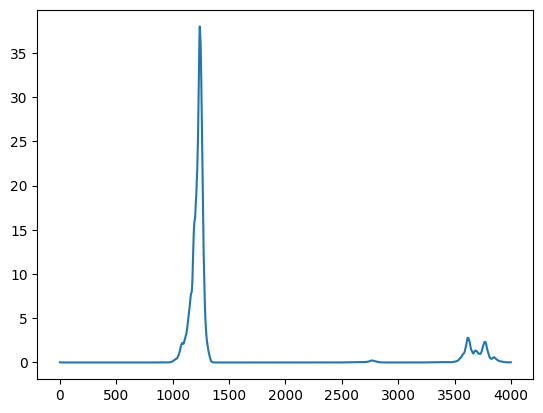

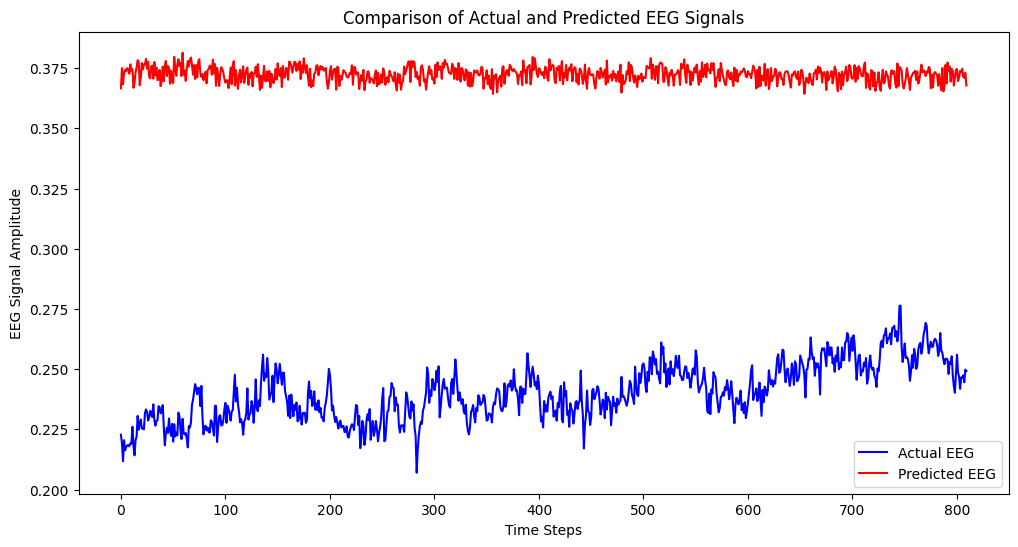

In [301]:
model.params["ext_exc_current"] = square_signals[0]
model.params['duration']=400
model.params["mue_ext_mean"], model.params["mui_ext_mean"], model.params["sigma_ou"]=[ 0.1335, -0.2672,  0.2688]
model.run()
plt.plot(model['rates_exc'][0])
plt.show()
rates_exc_tensor = torch.tensor(model['rates_exc'][0]).float().unsqueeze(1)  # Add channel dimension
rates_inh_tensor = torch.tensor(model['rates_inh'][0]).float().unsqueeze(1)  # Add channel dimension
input_data_tensor = torch.cat((rates_exc_tensor, rates_inh_tensor), dim=1)
# Make prediction
cnn_model.eval()
with torch.no_grad():
    prediction = cnn_model(input_data_tensor)

# Convert prediction tensor to numpy array
prediction_array = prediction.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(np.array(values_O1[0])/1000, label='Actual EEG', color='blue')
plt.plot(prediction_array, label='Predicted EEG', color='red')
#lt.plot(model['rates_exc'][0])
plt.title('Comparison of Actual and Predicted EEG Signals')
plt.xlabel('Time Steps')
plt.ylabel('EEG Signal Amplitude')
plt.legend()
plt.show()